# 🏎️ Analyzing Formula 1 Telemetry Data and Making Lap Time Predictions Using Machine Learning

## Introduction
Formula 1 racing combines speed, precision, and strategy, making it a fascinating arena for data analysis. In this tutorial, we will explore how to analyze Formula 1 telemetry data and predict lap times using machine learning techniques.

By following this comprehensive guide, you will gain a deeper understanding of how to leverage machine learning for predictive analytics in Formula 1, enhancing your skills and contributing to the broader data science community.

## Motivation

Suppose you work for a racing team like Mercedes and the strategy engineer wants to know in advance an estimate of what Hamilton's lap time will be, he gives you the following information:
- _Sector 1 time_: 25.398 seconds
- _Sector 2 time_: 28.589 seconds
- _#1 Speed Trap velocity_: 213 km/h
- _#2 Speed Trap velocity_: 251 km/h
- _Compound_:	Medium
- _Tyre life_: 8 laps

![image.png](./images/sector-time.png)


You can predict the sector 3 time:
##### 🙋 Sector 3 time will be around: **≈22.326 seconds** (±0.120 margin)

This notebook shows how to do it.



## Data Description
### Dataset Overview

- We gonna use [FastF1 API](https://github.com/theOehrly/Fast-F1) to fetch Hamilton's car data from the 2024 Emilia Romagna GP.
- The dataset includes telemetry data from all drivers, with variables such as speed, throttle position, gear, RPM, and lap time.

In [34]:
import fastf1
import ydf
import fastf1.plotting
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.io as pio
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings

pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
plt.style.use("dark_background")

GRAND_PRIX = 'Imola'
YEAR = 2024
DRIVER = 'HAM'
SESSION = 'Race'  # "FP1" / "Sprint" / "Sprint Qualifying" / "Qualifying"

### Variables

- The main variables in the dataset:
    - Speed (in km/h)
    - Throttle Position (percentage)
    - Gear (current gear)
    - RPM (revolutions per minute)
    - Lap Time (seconds)

In [32]:
session = fastf1.get_session(YEAR, GRAND_PRIX, SESSION)
session.load(weather=False, messages=False)
laps = session.laps
driver_laps = laps.pick_driver(DRIVER)
driver_laps.head(1).transpose()

core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.3.6]
INFO:fastf1.fastf1.core:Loading data for Emilia Romagna Grand Prix - Race [v3.3.6]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data

,315
Time,0 days 00:57:04.002000
Driver,HAM
DriverNumber,44
LapTime,0 days 00:01:27.111000
LapNumber,1.0
Stint,1.0
PitOutTime,NaT
PitInTime,NaT
Sector1Time,NaT
Sector2Time,0 days 00:00:29.112000


### Data Preprocessing

Data cleaning, handling missing values, converting units if necessary, and normalizing features.

There are a lot of data available, but we are only interested in the following:


In [3]:
columns = [
    'LapNumber',
    'Stint',
    'Sector1Time',
    'Sector2Time',
    'Sector3Time',
    'SpeedI1',
    'SpeedI2',
    'Compound',
    'TyreLife'
]
df = driver_laps[columns]
df.head(1).transpose()

,315
LapNumber,1.0
Stint,1.0
Sector1Time,NaT
Sector2Time,0 days 00:00:29.112000
Sector3Time,0 days 00:00:27.601000
SpeedI1,215.0
SpeedI2,254.0
Compound,MEDIUM
TyreLife,1.0


### Data sanitization

We can see that some data is in the `timedelta` format. We need to to convert it to seconds, so we can work with. Also, we can se a missing value in `Sector1Time`, we must clean it.

In [4]:
columns_in_timedelta = [
    'Sector1Time',
    'Sector2Time',
    'Sector3Time'
]

for col in columns_in_timedelta:
    col_total_seconds = df[col].dt.total_seconds()
    df[col] = None
    df[col] = df[col].astype(float)
    df.loc[:, col] = col_total_seconds

df = df.dropna()
df.head(1).transpose()

,317
LapNumber,3.0
Stint,1.0
Sector1Time,25.398
Sector2Time,28.589
Sector3Time,27.235
SpeedI1,213.0
SpeedI2,251.0
Compound,MEDIUM
TyreLife,3.0


Now let's see the data we're working on

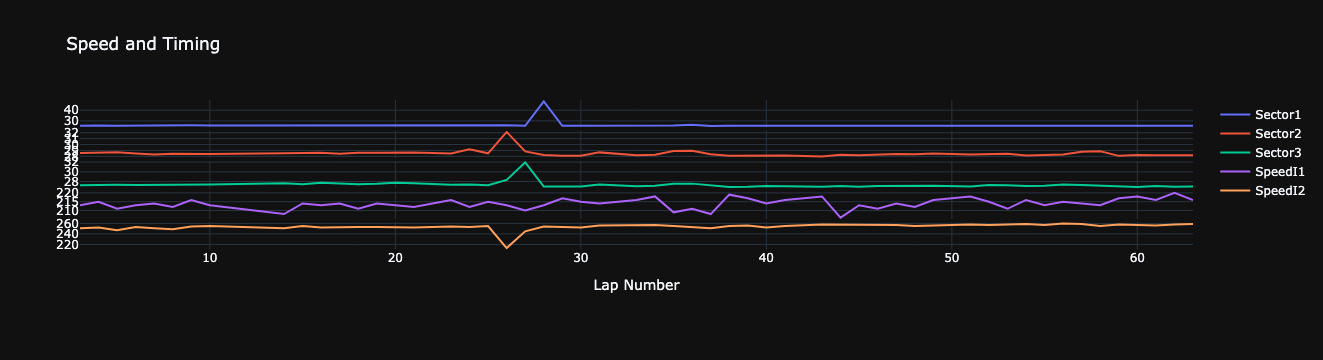

In [5]:
def plot_sectors_data(data):
    layout = dict(
        title="Speed and Timing",
        xaxis_title="Lap Number",
        template="plotly_dark",
        hovermode='x unified',
        hoversubplots="axis",
        grid=dict(rows=6, columns=1)
    )
    data = [
        go.Scatter(x=data["LapNumber"], y=data["Sector1Time"],
                   xaxis="x", yaxis="y", name='Sector1'),
        go.Scatter(x=data["LapNumber"], y=data["Sector2Time"],
                   xaxis="x", yaxis="y2", name='Sector2'),
        go.Scatter(x=data["LapNumber"], y=data["Sector3Time"],
                   xaxis="x", yaxis="y3", name='Sector3'),
        go.Scatter(x=data["LapNumber"], y=data["SpeedI1"],
                   xaxis="x", yaxis="y4", name='SpeedI1'),
        go.Scatter(x=data["LapNumber"], y=data["SpeedI2"],
                   xaxis="x", yaxis="y5", name='SpeedI2'),
    ]
    fig = go.Figure(data=data, layout=layout)
    fig.show()


plot_sectors_data(df)

We can see that something happened at 26th lap, this was Hamilton going out of track at acqua minerale, then pitting at the next lap.

This will hurt our model since these lap times are not relevant to lap time prediction, so we'll remove it

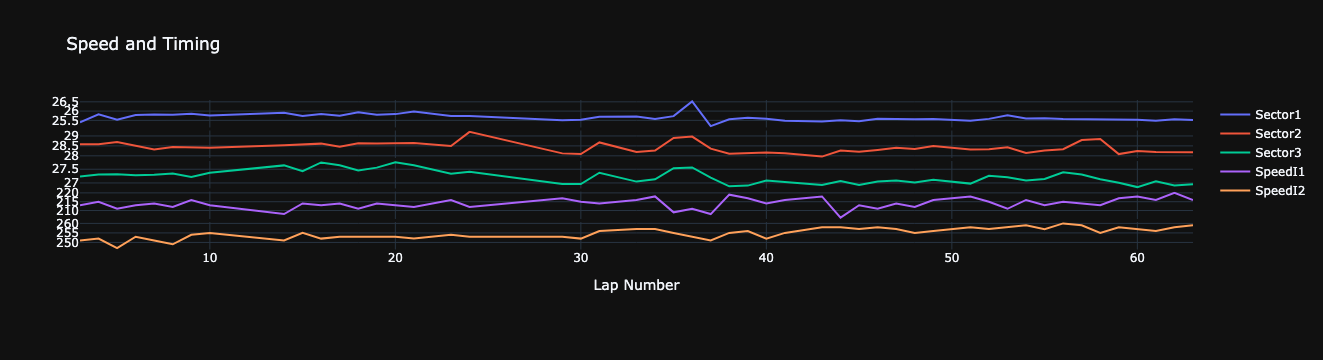

In [6]:
df = df.drop(df[(df.LapNumber < 29) & (df.LapNumber > 24)].index)

plot_sectors_data(df)

We can see that the data is smoother

Let's see the distribution of our features and label, we can drop the `LapNumber` column now

<Axes: xlabel='Stint', ylabel='SpeedI2'>

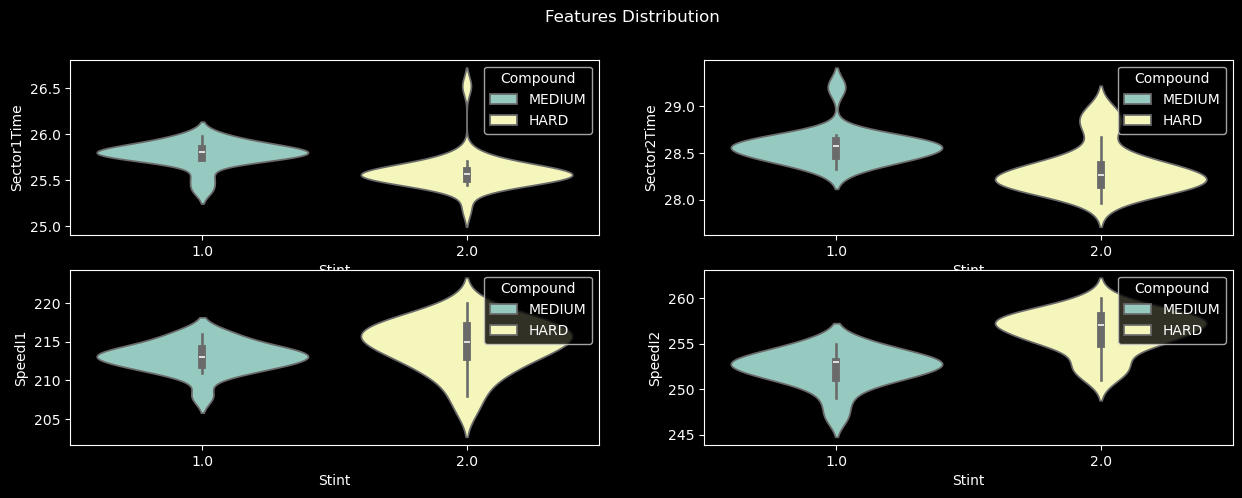

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Features Distribution')
sns.violinplot(data=df, x="Stint", y="Sector1Time",
               hue="Compound", ax=axes[0, 0])
sns.violinplot(data=df, x="Stint", y="Sector2Time",
               hue="Compound", ax=axes[0, 1])
sns.violinplot(data=df, x="Stint", y="SpeedI1", hue="Compound", ax=axes[1, 0])
sns.violinplot(data=df, x="Stint", y="SpeedI2", hue="Compound", ax=axes[1, 1])

We can see that the features are not too much sparse, let's see the label:

Text(0.5, 1.0, 'Label distribution')

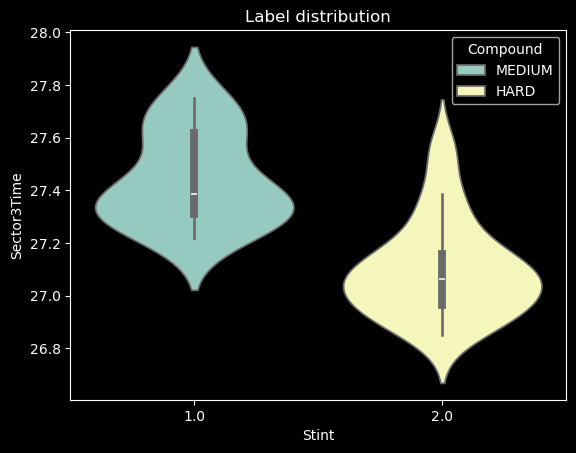

In [12]:
df.drop('LapNumber', axis=1, inplace=True)

sns.violinplot(data=df, x="Stint", y="Sector3Time",
               hue="Compound").set_title("Label distribution")

Also looking good, now let's see a pair plot of all dataset

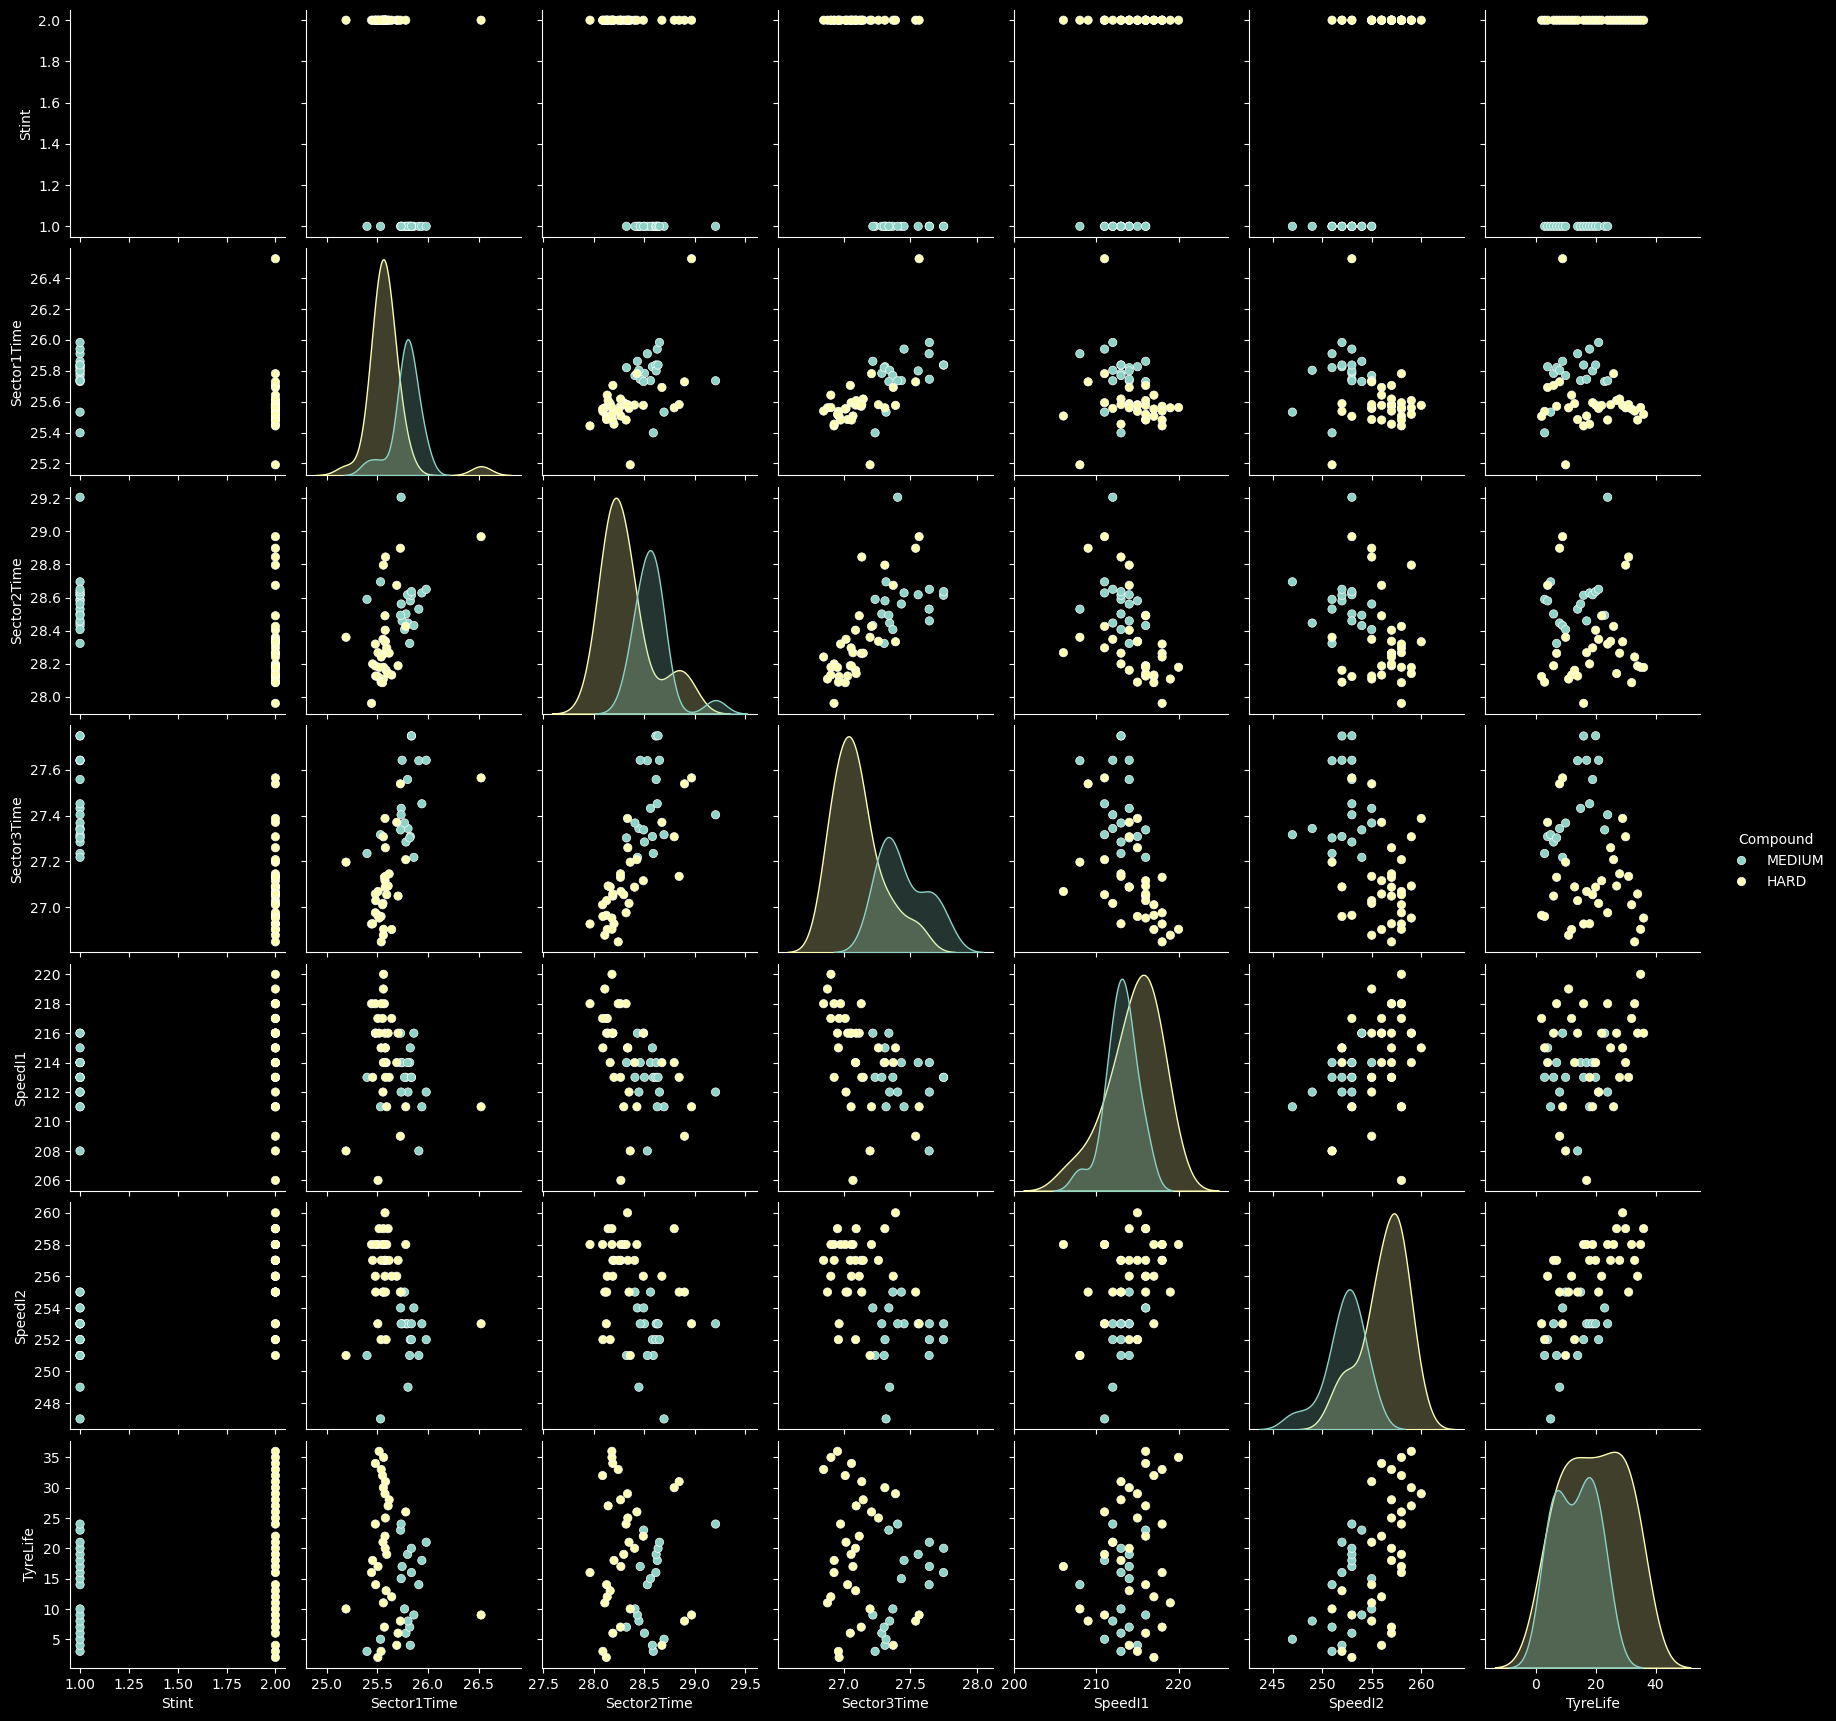

In [13]:
sns.pairplot(df, hue="Compound")

We can see that our data is concise, not too sparse, which is good for our model.

## Methodology
### Data Preparation

Randomly splitting the data into training (90%) and testing (10%) sets

In [14]:
df = df.sample(frac=1)
split_idx = len(df) - 5
train_ds = df.iloc[:split_idx]
test_ds = df.iloc[split_idx:]

print(f"Train dataset length: {len(train_ds)} \n"
      f"Test dataset length: {len(test_ds)}")

Train dataset length: 45 
Test dataset length: 5


### Building the Predictive Model
We will use [YDF](https://github.com/google/yggdrasil-decision-forests) Gradient Boosted Trees to perform the regression.

- Gradient Boosted Trees is a type of Decision forests algorithms. 
- Decision forests are a family of interpretable machine learning algorithms that excel with tabular data. 
- Decision forests produce great results in machine learning competitions, and are heavily used in many industrial tasks.

In [15]:
model = ydf.GradientBoostedTreesLearner(label="Sector3Time",
                                        task=ydf.Task.REGRESSION).train(train_ds)

Train model on 45 examples
Model trained in 0:00:00.080270


### Evaluating Model Performance

YDF uses Root Mean Square Error (RMSE) to evaluate model performance.

In [16]:
model.evaluate(test_ds)

Evaluation()

## Prediction vs Actual

Let's see how our model performs

First let's see the features we're gonna use:



In [23]:
test_ds.head()

,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,Compound,TyreLife
369,2.0,25.617,28.264,27.146,213.0,257.0,HARD,28.0
355,2.0,25.484,28.126,27.029,216.0,255.0,HARD,14.0
321,1.0,25.820,28.323,27.303,214.0,251.0,MEDIUM,7.0
330,1.0,25.837,28.614,27.748,213.0,252.0,MEDIUM,16.0
323,1.0,25.861,28.431,27.218,216.0,254.0,MEDIUM,9.0


The true values (`y`) are:

In [24]:
y = test_ds['Sector3Time'].values
y

array([27.146, 27.029, 27.303, 27.748, 27.218])

And now there's the predictions (`y_hat`) based on our features:

In [25]:
y_hat = model.predict(test_ds)
y_hat

array([27.124872, 26.993294, 27.290007, 27.547873, 27.462208],
      dtype=float32)

#### That's a pretty close value! 👏

Well done, our model can give a pretty good prediction on how Hamilton lap will be with margin of error around:

In [29]:
error = np.around(y_hat - y, decimals=3)
error_mean = error.mean()

print(f"------------------------------------------\n"
      f"|         {error_mean:.3f} seconds\n"
      f"------------------------------------------")

------------------------------------------
|         -0.005 seconds
------------------------------------------


## Visualizations

Let's vizualize how close our predictions are from the true values

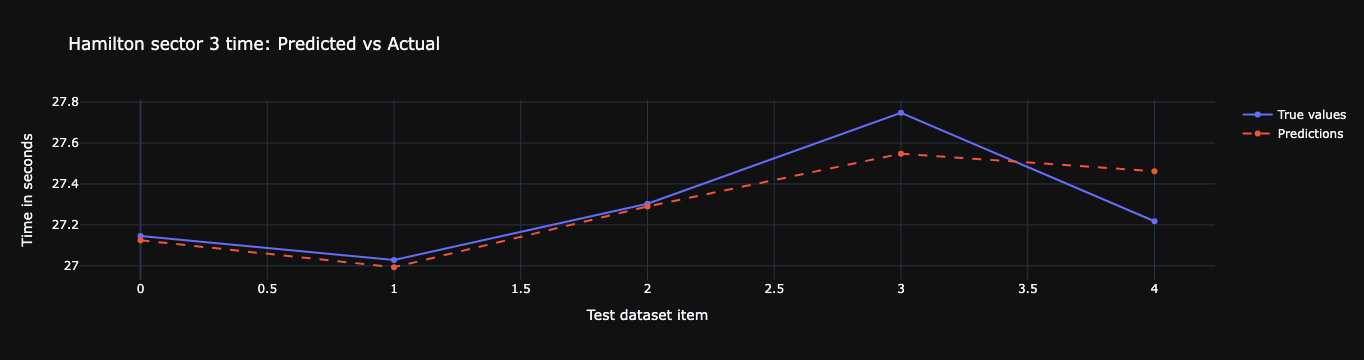

In [33]:
x = list(range(len(y)))

layout = dict(
    title="Hamilton sector 3 time: Predicted vs Actual",
    xaxis_title="Test dataset item",
    yaxis_title="Time in seconds",
    template="plotly_dark",
    hovermode='x unified',
)
data = [
    go.Scatter(x=x, y=y, name='True values'),
    go.Scatter(x=x, y=np.round(y_hat, decimals=3), name='Predictions', line=dict(dash='dash')),
]
fig = go.Figure(data=data, layout=layout)

fig.show()

### Feature Importance

Visualize feature importance to understand which variables most impact lap time predictions.

We can vizualize the loss on the "Training" tab

In [17]:
model.describe()

- *Sector1Time*, *Sector2Time*, _SpeedI1_ and _SpeedI2_ are the most important feature for predicting lap times.

We can view the dependence plot

In [18]:
model.analyze(test_ds)

### Vizualizing model tree

In [20]:
model.plot_tree()

## Results Interpretation
### Model Performance Analysis

The Gradient Boosted model had an RMSE ranging from 0.24 to 0.15 in validation, indicating that the model can learn from the patterns presented in our data and predict a value close to the real one.
### Insights and Conclusions

The model shows that the speed and times of sector 1 and sector 2 are the most significant characteristics. Future work could involve more data from the car, as well as the weather and other cars on the track
## Conclusion
In this tutorial we covered data fetching from [fastf1 API](https://github.com/theOehrly/Fast-F1), feature engineering to use data that are relevant to us, using a highly interpretable regression model to inform a race engineer

[YDF](https://ydf.readthedocs.io/en/latest/py_api/) provides other models that you can test and share your results

Happy analyzing, and may your lap time predictions be ever accurate!